In [2]:
import os
import numpy as np
from scipy.signal import *
from scipy.fft import fft
import matplotlib
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils import to_categorical
import keras.layers as layers
from keras.optimizers import SGD
from keras.initializers import random_uniform
from keras.callbacks import EarlyStopping
from google.colab import drive
import random
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [3]:
drive.mount('/content/gdrive')
data_path_mohab = 'gdrive/MyDrive/Left_Right_CNN_Data/mohab/'

fs = 256

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
def get_signals(data_path):

    cwd = os.path.abspath(data_path)
    files = [f for f in os.listdir(cwd) if os.path.isfile(os.path.join(cwd, f))]

    ## Method 1 gets the first sheet of a given file
    Left_Data = pd.DataFrame()
    Right_Data = pd.DataFrame()
    Center_Data = pd.DataFrame()
    for file in files:
        if file.endswith('.csv'):
          if file.startswith('Left'):
            Left = pd.read_csv(data_path+file)
            Left_Data = Left_Data.append(Left, ignore_index=True)
          elif file.startswith('Right'):
            Right = pd.read_csv(data_path+file)
            Right_Data = Right_Data.append(Right, ignore_index=True)
          else :
            Center = pd.read_csv(data_path+file)
            Center_Data = Center_Data.append(Center, ignore_index=True)

    Left_Data= Left_Data.drop(['timestamps','Right AUX'], axis = 1)
    Right_Data = Right_Data.drop(['timestamps','Right AUX'], axis = 1)
    Center_Data = Center_Data.drop(['timestamps','Right AUX'], axis = 1)
    Center_Data = Center_Data.dropna()

    return Left_Data, Right_Data, Center_Data

In [5]:
def get_windows(signal, window_size, window_stride):

    windows = []
    # windows_times = []
    window_features = []
    # if len(signal[0]) == len(time):
    for j in range(0, len(signal[0])-window_size, window_stride):
        # window_time = time[j:j+window_size]
        # windows_times.append(window_time)

        for i in range(len(signal)):
            window_feature = signal[i][j:j+window_size]
            window_features.append(window_feature)
        windows.append(window_features)
        window_features = []
    windows = np.array(windows)
    # windows_times = np.array(windows_times)
    return windows

In [6]:
def get_labels(Left_Data, Right_Data, Center_Data):
    return ([0 for _ in range(Left_Data.shape[0])],
     [1 for _ in range(Right_Data.shape[0])],
     [2 for _ in range(Center_Data.shape[0])])

In [7]:
def cocatenate_and_randomize(Windows_Left_Data, Windows_Left_Labels, Windows_Right_Data, Windows_Right_Labels, Windows_Center_Data, Windows_Center_Labels):
    random.seed(4)
    Directions = np.concatenate((Windows_Left_Data, Windows_Right_Data, Windows_Center_Data), axis=0)
    Directions_Labels = np.concatenate((Windows_Left_Labels, Windows_Right_Labels, Windows_Center_Labels), axis=0)
    temp = list(zip(Directions, Directions_Labels))
    random.shuffle(temp)

    Directions_Randomized, Directions_Labels_Randomized = zip(*temp)
    # blinkingWithNoise_randomized and blinkingWithNoise_labels_randomized come out as tuples, and so must be converted to lists.
    return list(Directions_Randomized), list(Directions_Labels_Randomized)

In [33]:
def create_dataset_without_filter(data_pathes, fs=250.0, fc_low=1, fc_high=1):

    # inputs:
    # outputs:
    Left_Data = pd.DataFrame()
    Right_Data = pd.DataFrame()
    Center_Data = pd.DataFrame()

    X = []
    Y = []
    Wt = []
    i = 0
    # signal_files, label_files = get_files(data_path)

    # for i in range(len(signal_files)):
    # file_idx = i
    for data_path in data_pathes:
      Left_Data_File, Right_Data_File, Center_Data_File = get_signals(data_path)
      Left_Data = pd.concat([Left_Data, Left_Data_File], axis=0)
      Right_Data = pd.concat([Right_Data, Right_Data_File], axis=0)
      Center_Data = pd.concat([Center_Data, Center_Data_File], axis=0)

    # interval_corrupt, blinks = get_blinks(label_files, data_path, file_idx, signals)
    # time = signals[:,0]
    # signal = signals[:,1:3]
    # filtered_signal_blinks = butter_filter(blinks, fs, fc_low, 'high')
    # filtered_signal_noBlinks = butter_filter(noBlinks, fs, fc_low, 'high')
    #filtered_signal = butter_filter(filtered_signal, fs, fc = fc_low)
    Left_Data = np.array(Left_Data)
    Right_Data = np.array(Right_Data)
    Center_Data = np.array(Center_Data)
    Left_Data = np.transpose(Left_Data)
    Right_Data = np.transpose(Right_Data)
    Center_Data = np.transpose(Center_Data)

    windows_Left_Data = get_windows(Left_Data, 400, 100)
    windows_Right_Data = get_windows(Right_Data, 400, 100)
    windows_Center_Data = get_windows(Center_Data, 400, 100)
    # while i < len(windows_blinks):
    #   if np.max(abs(windows_blinks[i])) < 200 :
    #     # plt.plot(np.reshape(windows_blinks[i], [200,4]))
    #     windows_blinks = np.delete(windows_blinks, i, axis=0)
    #     i -= 1
    #     # print(j)
    #     # plt.show()
    #   i += 1

    # cleaned_windows, cleaned_windows_times = clean_windows(windows, windows_times, interval_corrupt)
    Left_Labels, Right_Labels, Center_Labels = get_labels(windows_Left_Data, windows_Right_Data, windows_Center_Data)

    # for j in range(len(windows)):
    #     X.append(windows[j])00
    #     Y.append(labels[j])
    #     Wt.append(windows_times[j])

    #     X = np.array(X)
    #     Y = np.array(Y)
    #     Wt = np.array(Wt)

    Eye_Directions_Data, Eye_Directions_Labels = cocatenate_and_randomize(windows_Left_Data, Left_Labels, windows_Right_Data, Right_Labels, windows_Center_Data, Center_Labels)

    return np.array(Eye_Directions_Data), np.array(Eye_Directions_Labels)

In [9]:
data_pathes = [data_path_mohab]

Eye_Directions_Data, Eye_Directions_Labels = create_dataset_without_filter(data_pathes, fs=250.0, fc_low=1, fc_high=1)

<ipython-input-4-4fb9c52ed58b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Center_Data = Center_Data.append(Center, ignore_index=True)
<ipython-input-4-4fb9c52ed58b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Left_Data = Left_Data.append(Left, ignore_index=True)
<ipython-input-4-4fb9c52ed58b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Left_Data = Left_Data.append(Left, ignore_index=True)
<ipython-input-4-4fb9c52ed58b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Left_Data = Left_Data.append(Left, ignore_index=True)
<ipython-input-4-4fb9c52ed58b>:14: FutureWarning: The frame.append method is deprecated and will b

In [10]:
print(Eye_Directions_Data.shape)

(1276, 4, 400)


In [29]:
freq_domain_sample_rate = 256/2

ranges = [(0, 4), (4, 8), (9, 13), (14, 30), (30, 100)]

def time_to_freq_domain(directions):
    freq_domain_data = []
    freq_domain_data_window = []
    for i in range(directions.shape[0]):
      for j in range(directions.shape[1]):
        F,PSD = welch(directions[i, j], fs, nperseg=directions.shape[2])

        data = [PSD[(F >= lower) & (F <= upper)] for lower, upper in ranges]

        for i in range(len(data)):
          data[i] = np.pad(data[i], (0, len(data[4])-len(data[i])), mode='constant')
        freq_domain_data_window = np.vstack([freq_domain_data_window, data]) if len(freq_domain_data_window) else data
        print(np.shape(freq_domain_data_window))
      freq_domain_data.append(freq_domain_data_window)
      freq_domain_data_window = []
    return freq_domain_data

In [30]:
Eye_Directions_freq_domain_data = time_to_freq_domain(Eye_Directions_Data)
Eye_Directions_freq_domain_data = np.array(Eye_Directions_freq_domain_data)

(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 107)
(20, 107)
(5, 107)
(10, 107)
(15, 1

KeyboardInterrupt: ignored

In [13]:
print(Eye_Directions_freq_domain_data.shape)

(1276, 20, 107)


In [ ]:
# early_stopping = EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=20, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

In [14]:
def create_model(X_train):
  model = Sequential([

      # first convolution block
      layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape = X_train[0].shape),
      layers.MaxPool1D(),

      # second convolution block
      layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
      layers.MaxPool1D(),

      # third convolution block
      layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
      layers.MaxPool1D(),

      # classifier head
      layers.Flatten(),
      layers.Dense(16, activation='relu', input_shape = (500,)),
      layers.Dense(3, activation='softmax'),
  ])
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
  )
  return model

In [15]:
# Define the number of cross-validation folds
n_folds = 5

# Define the cross-validation iterator
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, val_index in cv.split(Eye_Directions_freq_domain_data, Eye_Directions_Labels):
    # Split the data into training and validation sets
    X_train, X_val = Eye_Directions_freq_domain_data[train_index], Eye_Directions_freq_domain_data[val_index]
    Y_train, Y_val = Eye_Directions_Labels[train_index], Eye_Directions_Labels[val_index]
    X_train = np.transpose(X_train, (0, 2, 1))
    X_val = np.transpose(X_val, (0, 2, 1))

    #create model
    model = create_model(X_train)

    # Fit the model on the training data
    Y_train = to_categorical(Y_train,num_classes=3)
    Y_val = to_categorical(Y_val,num_classes=3)
    history = model.fit(
    X_train,
    Y_train,
    epochs = 30,
    batch_size = 32
    )

    # Evaluate the model on the validation data
    loss, acc = model.evaluate(X_val, Y_val, verbose = 0)

    # Print the validation accuracy for this fold
    print('Validation accuracy: %.3f' % acc)

# history = model.fit(
#     X_train,
#     Y_train,
#     validation_data = (X_val, Y_val),
#     epochs = 200,
#     batch_size = 32,
#     callbacks = [early_stopping]
# )

Epoch 1/30
32/32 [==============================] - 2s 14ms/step - loss: 2.7162 - categorical_accuracy: 0.7147
Epoch 2/30
32/32 [==============================] - 0s 13ms/step - loss: 0.6576 - categorical_accuracy: 0.8451
Epoch 3/30
32/32 [==============================] - 0s 13ms/step - loss: 0.6603 - categorical_accuracy: 0.8196
Epoch 4/30
32/32 [==============================] - 0s 13ms/step - loss: 0.8352 - categorical_accuracy: 0.8559
Epoch 5/30
32/32 [==============================] - 0s 13ms/step - loss: 0.6518 - categorical_accuracy: 0.8441
Epoch 6/30
32/32 [==============================] - 0s 14ms/step - loss: 0.8906 - categorical_accuracy: 0.8206
Epoch 7/30
32/32 [==============================] - 0s 13ms/step - loss: 0.5439 - categorical_accuracy: 0.8647
Epoch 8/30
32/32 [==============================] - 0s 13ms/step - loss: 0.2811 - categorical_accuracy: 0.8725
Epoch 9/30
32/32 [==============================] - 0s 13ms/step - loss: 0.2742 - categorical_accuracy: 0.8745
E

In [16]:
model.save('Downloads')
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model('Downloads')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
model_no_quant_tflite = converter.convert()

# Save the model to disk
open('model.tflite', "wb").write(model_no_quant_tflite)

111068

In [32]:
# # Prepare the test data
# x_test_ = df_test.copy()
# x_test_ = x_test_.reshape((df_test.size, 1))
# x_test_ = x_test_.astype(np.float32)
# Initialize the TFLite interpreter
# filename = 'BlinkingCNN.tflite'
# interpreter = tf.lite.Interpreter(model_path=filename)
interpreter = tf.lite.Interpreter(model_content=model_no_quant_tflite)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.allocate_tensors()
# Invoke the interpreter

X_test = np.float32(Eye_Directions_freq_domain_data)
X_test = np.transpose(X_test, (0, 2, 1))
y_pred = np.empty(len(X_test), dtype=object)
for i in range(len(X_test)):
  print((X_test[i]).shape)
  interpreter.set_tensor(input_details[0]["index"], [X_test[i]])
  interpreter.invoke()
  y_pred[i] = interpreter.get_tensor(output_details[0]["index"])


(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)
(107, 20)


In [18]:
y_pred = np.array(y_pred)

In [31]:
print(y_pred)

[array([[1.9163711e-36, 0.0000000e+00, 1.0000000e+00]], dtype=float32)
 array([[0., 0., 1.]], dtype=float32) array([[0., 0., 1.]], dtype=float32)
 ... array([[9.8361188e-01, 1.6385535e-02, 2.6326099e-06]], dtype=float32)
 array([[0., 0., 1.]], dtype=float32)
 array([[1.2390173e-04, 9.9987066e-01, 5.3943568e-06]], dtype=float32)]


In [20]:
print(Eye_Directions_Labels)
ypred = [0 for _ in range(len(Eye_Directions_Labels))]
for i in range(len(Eye_Directions_Labels)):
  if y_pred[i][0][0] == max(y_pred[i][0]):
    ypred[i] = 0
  elif y_pred[i][0][1] == max(y_pred[i][0]):
    ypred[i] = 1
  else:
    ypred[i] = 2

[2 2 2 ... 0 2 1]


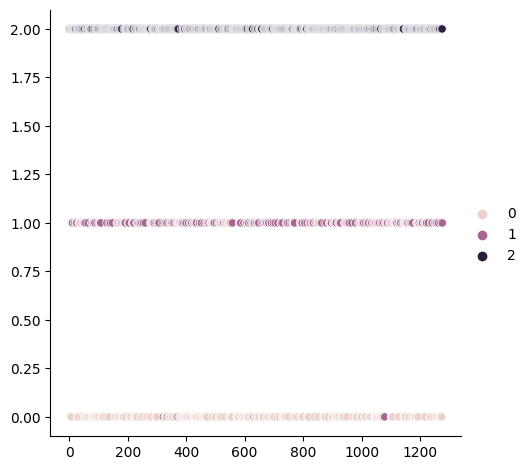

In [21]:
# for i in range(len(y_pred)):
#   print(np.shape(y_pred[i]))

z = len(y_pred)
Range = np.linspace(0, 1276, z)
sns.relplot(x=Range, y=ypred, hue=Eye_Directions_Labels)

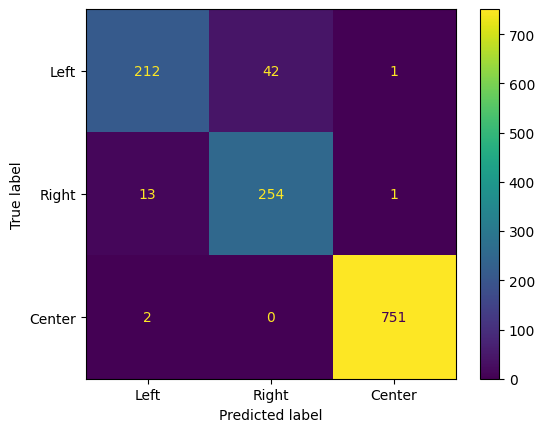

In [22]:
confusion_matrix = metrics.confusion_matrix(Eye_Directions_Labels, ypred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Left', 'Right', 'Center'])

cm_display.plot()
plt.show()